In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(100, 128, 7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
            nn.Tanh(),  # Normalize MNIST images to range [-1, 1]
        )

    def forward(self, x):
        return self.network(x)



In [ ]:
def train_discriminator(discriminator, real_images, fake_images, real_labels, fake_labels, optimizer_d, criterion):
    discriminator.zero_grad()
    outputs = discriminator(real_images)
    d_loss_real = criterion(outputs, real_labels)
    outputs = discriminator(fake_images.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()
    return d_loss.item(), outputs.mean().item()

def train_generator(generator, discriminator, fake_images, real_labels, optimizer_g, criterion):
    generator.zero_grad()
    outputs = discriminator(fake_images)
    g_loss = criterion(outputs, real_labels)
    g_loss.backward()
    optimizer_g.step()
    return g_loss.item()


In [ ]:
def show_images(images, num_images=25):
    images = (images + 1) / 2  # Rescale images to range [0, 1]
    grid = make_grid(images[:num_images], nrow=5)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# Hyperparameters
lr = 0.0002
batch_size = 64
epochs = 50
pretrain_epochs = 0  # Pre-train the discriminator

# Data loading
train_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Epoch [1/50], Step [200/938], d_loss: 0.0012, g_loss: 8.7264, D(real): 0.00
Epoch [1/50], Step [400/938], d_loss: 0.0518, g_loss: 9.2591, D(real): 0.02
Epoch [1/50], Step [600/938], d_loss: 0.2425, g_loss: 6.5377, D(real): 0.07
Epoch [1/50], Step [800/938], d_loss: 0.1134, g_loss: 6.1545, D(real): 0.06


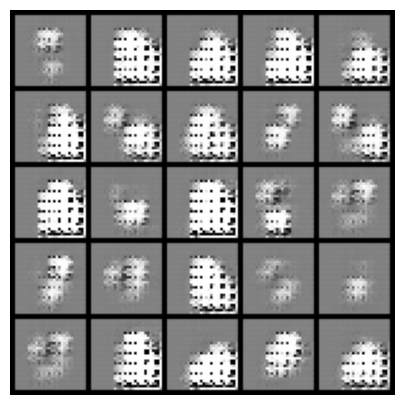

Generated images from Epoch 1
Epoch [2/50], Step [200/938], d_loss: 0.1692, g_loss: 6.3947, D(real): 0.06
Epoch [2/50], Step [400/938], d_loss: 0.2261, g_loss: 3.9438, D(real): 0.10
Epoch [2/50], Step [600/938], d_loss: 0.2451, g_loss: 4.6524, D(real): 0.08
Epoch [2/50], Step [800/938], d_loss: 0.3717, g_loss: 4.2508, D(real): 0.19


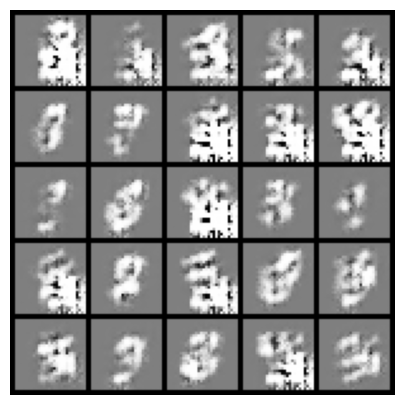

Generated images from Epoch 2
Epoch [3/50], Step [200/938], d_loss: 0.3132, g_loss: 4.4861, D(real): 0.14
Epoch [3/50], Step [400/938], d_loss: 0.3522, g_loss: 4.6448, D(real): 0.06
Epoch [3/50], Step [600/938], d_loss: 0.3150, g_loss: 3.7157, D(real): 0.15
Epoch [3/50], Step [800/938], d_loss: 0.4155, g_loss: 4.0479, D(real): 0.07


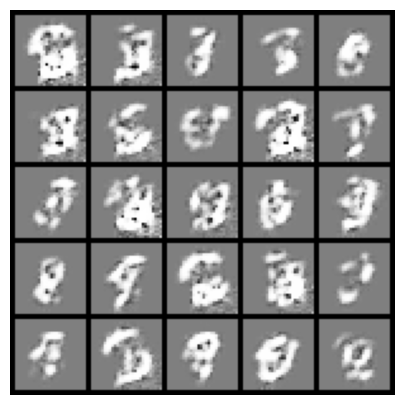

Generated images from Epoch 3
Epoch [4/50], Step [200/938], d_loss: 0.3104, g_loss: 3.4948, D(real): 0.14
Epoch [4/50], Step [400/938], d_loss: 0.4325, g_loss: 2.7140, D(real): 0.17
Epoch [4/50], Step [600/938], d_loss: 0.6172, g_loss: 4.2466, D(real): 0.12
Epoch [4/50], Step [800/938], d_loss: 0.3440, g_loss: 3.0967, D(real): 0.12


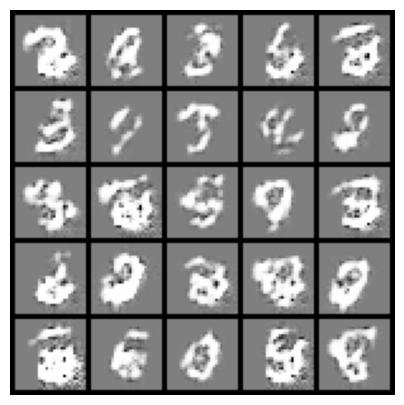

Generated images from Epoch 4
Epoch [5/50], Step [200/938], d_loss: 0.2808, g_loss: 3.3581, D(real): 0.12
Epoch [5/50], Step [400/938], d_loss: 0.5375, g_loss: 2.9481, D(real): 0.24
Epoch [5/50], Step [600/938], d_loss: 0.4130, g_loss: 3.1600, D(real): 0.19


In [ ]:
# Initialize models and move to device
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Optimizers
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Pre-train the discriminator
for epoch in range(pretrain_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        noise = torch.randn(real_images.size(0), 100, 1, 1).to(device)
        fake_images = generator(noise)

        # Train discriminator on real and generated data
        d_loss, _ = train_discriminator(discriminator, real_images, fake_images, real_labels, fake_labels, optimizer_d, criterion)

        if (i + 1) % 200 == 0:
            print(f'Pre-Training Epoch [{epoch + 1}/{pretrain_epochs}], Step [{i + 1}/{len(train_loader)}], d_loss: {d_loss:.4f}')

# Normal training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        # Generate fake images
        noise = torch.randn(real_images.size(0), 100, 1, 1).to(device)
        fake_images = generator(noise)

        # Train discriminator
        d_loss, d_real_score = train_discriminator(discriminator, real_images, fake_images, real_labels, fake_labels, optimizer_d, criterion)

        # Train generator
        g_loss = train_generator(generator, discriminator, fake_images, real_labels, optimizer_g, criterion)

        # Logging the process
        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}, D(real): {d_real_score:.2f}')

    # Displaying generated images at the end of each epoch
    with torch.no_grad():
        test_noise = torch.randn(batch_size, 100, 1, 1).to(device)
        generated_images = generator(test_noise)
        show_images(generated_images)
        print(f'Generated images from Epoch {epoch + 1}')


In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')